# L'algorithme quantique HHL avec Qiskit
Ce notebook illustre une implémentation de l'algorithme HHL (Harrow, Hassidim, Lloyd) pour résoudre un système linéaire.

In [6]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import expm
from qiskit.quantum_info import Statevector

# Système à résoudre : A x = b
A = np.array([[1, 1], [1, 3]], dtype=float)
b = np.array([1, 0], dtype=float)
b = b / np.linalg.norm(b)

# Décalage spectral pour rendre A définie positive avec valeurs propres > 1
eigvals, eigvecs = np.linalg.eigh(A)
min_eig = np.min(eigvals)
alpha = 1.1 - min_eig if min_eig < 1.1 else 0  # On veut min eig > 1
A_shifted = A + alpha * np.eye(2)
eigvals, eigvecs = np.linalg.eigh(A_shifted)

n_phase = 1
n_ancilla = 1
n_solution = 1
n_qubits = n_phase + n_ancilla + n_solution

qc = QuantumCircuit(n_qubits)

theta = 2 * np.arccos(b[0])
qc.ry(theta, 2)
qc.h(0)

t = np.pi / (eigvals[1] - eigvals[0])
U = expm(1j * A_shifted * t)
U_gate = UnitaryGate(U)
qc.append(U_gate.control(1), [0,2])

qc.h(0)

for idx, eig in enumerate(eigvals):
    val = 1 / eig
    if np.abs(val) > 1:
        val = np.sign(val)
    angle = -2 * np.arcsin(val)
    if idx == 0:
        qc.cry(angle, 0, 1)
    else:
        qc.x(0)
        qc.cry(angle, 0, 1)
        qc.x(0)

state = Statevector.from_instruction(qc).data

print("Amplitudes non nulles :")
for idx, amp in enumerate(state):
    if np.abs(amp) > 1e-6:
        print(format(idx, f'0{n_qubits}b'), amp)

# Extraction de la solution (phase et ancilla à 0)
solution = []
for idx, amp in enumerate(state):
    binaire = format(idx, f'0{n_qubits}b')
    if binaire[:2] == '00':
        solution.append(amp)
solution = np.array(solution)
norm = np.linalg.norm(solution)
if norm > 0:
    solution = solution / norm
else:
    print("Aucune amplitude extraite, vérifiez la correspondance phase/valeur propre et la QPE.")

print("Vecteur solution normalisé (approximation HHL Qiskit, matrice décalée) :")
print(solution)
print("Solution classique (matrice décalée) :", np.linalg.solve(A_shifted, np.array([1, 0])))

Amplitudes non nulles :
000 (0.6004481466768739+0.32129454620568054j)
001 (0.157931525571582-0.13841005364568815j)
010 (-0.15805350407468977-0.08457304623045642j)
011 (-0.34463484311982323+0.3020354989401261j)
100 (-0.11691897192583796-0.3212945462056801j)
101 (0.050367369653683304+0.138410053645688j)
110 (0.03077610166333569+0.0845730462304563j)
111 (-0.10991061142563122-0.3020354989401258j)
Vecteur solution normalisé (approximation HHL Qiskit, matrice décalée) :
[0.84255864+0.45084575j 0.2216121 -0.19421925j]
Solution classique (matrice décalée) : [ 0.81323632 -0.23141346]


# Régression linéaire quantique 2x2 avec HHL

Ce bloc de code montre comment utiliser l’algorithme HHL pour approximer la solution d’un problème de régression linéaire sur deux points, c’est-à-dire résoudre (A x = b) où (A) est la matrice des covariances et (b) le vecteur des ordonnées.  
On prépare l’état quantique correspondant à (b), puis on applique les étapes principales de HHL : estimation de phase, rotation conditionnelle, et extraction de la solution.  
La solution quantique est comparée à la solution classique obtenue par inversion de la matrice (A).


In [6]:
import numpy as np
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import expm
from qiskit.quantum_info import Statevector

# Données d'entraînement
X = np.array([[1, 1],
              [1, 2],
              [1, 3]], dtype=float)
y = np.array([1, 2, 3], dtype=float)

# Matrice A et vecteur b
A = X.T @ X
b = X.T @ y
b_norm = b / np.linalg.norm(b)

print("A =\n", A)
print("b =", b)
print("b normalisé =", b_norm)

# Décomposition spectrale de A
eigvals, eigvecs = np.linalg.eigh(A)
print("Valeurs propres :", eigvals)

# Paramètres
n_phase = 2    # 2 qubits de phase (meilleure résolution)
n_ancilla = 1
n_solution = 1
n_qubits = n_phase + n_ancilla + n_solution

qc = QuantumCircuit(n_qubits)

# Indices :
# q0, q1 : qubits de phase
# q2 : ancilla
# q3 : solution

# Préparer |b> sur qubit solution (q3)
# Pour passer de 2 composantes à 1 qubit solution, on fait une rotation Ry:
theta_b = 2 * np.arccos(b_norm[0])  # |b> = cos(theta/2)|0> + sin(theta/2)|1>
qc.ry(theta_b, 3)

# Qubits indices :
# phase : q0, q1
# ancilla : q2
# solution : q3

# Hadamards sur qubits de phase pour QPE
qc.h([0,1])

# Controlled unitaries for QPE
# U = exp(i A t), mais on applique les puissances 2^k pour QPE
# On choisit t = pi / (max_eig - min_eig) pour normaliser

t = np.pi / (eigvals[-1] - eigvals[0])

# U = exp(i A t)
U = expm(1j * A * t)
U_gate = UnitaryGate(U)

# On applique U^(2^k) contrôlé par q_k sur solution
for k in range(n_phase):
    # Puissance 2^k
    Uk = UnitaryGate(expm(1j * A * t * (2**k)))
    # contrôle sur q_k, cible sur solution q3
    ctrl_qubit = k
    qc.append(Uk.control(1), [ctrl_qubit, 3])

# Inverse QFT sur qubits de phase (2 qubits)
def inverse_qft(circuit, qubits):
    circuit.swap(qubits[0], qubits[1])
    circuit.h(qubits[1])
    circuit.cp(-np.pi/2, qubits[0], qubits[1])
    circuit.h(qubits[0])

inverse_qft(qc, [0,1])

# Rotation conditionnelle sur ancilla (q2) en fonction des valeurs propres estimées
# L'estimation de la valeur propre est codée sur 2 qubits phase → 4 valeurs possibles (0..3)
# On approxime ces valeurs propres pour appliquer la rotation conditionnelle

# On prépare un tableau des angles de rotation conditionnelle
# angle = -2 * arcsin(C / lambda), avec C=1 (constante de HHL)
# Ici, on approxime lambda depuis la lecture binaire

# Définir les valeurs propres "quantifiées"
valeurs_propres_q = np.linspace(eigvals[0], eigvals[-1], 4)  # 4 valeurs pour 2 qubits

C = 1.0

# Pour appliquer une rotation contrôlée par 2 qubits de phase,
# on fait une séquence de portes CRY contrôlées par ces 2 qubits
# Pour simplifier, on applique des CRY conditionnelles via des portes multi-controles

# Pour chaque valeur propre approximée, on applique la rotation sur ancilla conditionnelle

from qiskit.circuit.library import MCMT

for i, lam in enumerate(valeurs_propres_q):
    inv_lam = C / lam
    if np.abs(inv_lam) > 1:
        inv_lam = np.sign(inv_lam)  # clamp entre -1 et 1
    angle = -2 * np.arcsin(inv_lam)

    # i en binaire sur 2 bits
    bits = format(i, '02b')

    # contrôle sur les deux qubits de phase pour la valeur propre i
    ctrl_qubits = []
    for q_idx, bit in enumerate(bits):
        if bit == '1':
            ctrl_qubits.append(q_idx)

    # Construire la séquence de contrôles et appliquer CRY angle sur ancilla (q2)
    # Si aucun bit = 1 → rotation non contrôlée (c'est le cas i=0 = '00')
    if len(ctrl_qubits) == 0:
        qc.ry(angle, 2)
    elif len(ctrl_qubits) == 1:
        qc.cry(angle, ctrl_qubits[0], 2)
    else:
        # Double contrôle (2 qubits)
        qc.mcry(angle, ctrl_qubits, 2)

# Inverse QPE : refaire QFT et Hadamard → mais ici on a déjà fait inverse QFT, on inverse QPE maintenant

# Inverse des Hadamard sur qubits de phase pour finir inverse QPE
qc.h([0,1])

# --- Simulation ---

sim = Aer.get_backend('statevector_simulator')
qc_t = transpile(qc, sim)
result = sim.run(qc_t).result()
state = result.get_statevector()

print("Amplitudes non nulles :")
for idx, amp in enumerate(state):
    if np.abs(amp) > 1e-6:
        print(format(idx, f'0{n_qubits}b'), amp)

# Extraction de la solution sur la partie où phase=0 et ancilla=0
solution = []
index_to_component = []

for idx, amp in enumerate(state):
    binaire = format(idx, f'0{n_qubits}b')
    phase_bits = binaire[:2]
    ancilla_bit = binaire[2]
    solution_bit = binaire[3]

    if phase_bits == '00' and ancilla_bit == '0':
        solution.append(amp)
        index_to_component.append(solution_bit)

vec_sol = np.zeros(2, dtype=complex)
for bit, amp in zip(index_to_component, solution):
    vec_sol[int(bit)] = amp

if np.linalg.norm(vec_sol) > 0:
    vec_sol = vec_sol / np.linalg.norm(vec_sol)
else:
    print("Erreur : vecteur solution nul.")

print("\nVecteur solution normalisé (approximation HHL) :")
print(vec_sol)

# Solution classique
w_classique = np.linalg.solve(A, b)
w_classique_norm = w_classique / np.linalg.norm(w_classique)

print("\nSolution classique :", w_classique)
print("Solution classique normalisée :", w_classique_norm)



A =
 [[ 3.  6.]
 [ 6. 14.]]
b = [ 6. 14.]
b normalisé = [0.3939193  0.91914503]
Valeurs propres : [ 0.3605897 16.6394103]
Amplitudes non nulles :
0000 (-0.04671875920608391-0.016112033589500998j)
0001 (0.04681077826053174+0.016067302859285187j)
0010 (0.005928079742373773+0.04911545322531166j)
0011 (-0.0060200987968215824-0.04907072249509588j)
0100 (-0.19088855457425719+0.003876015429527327j)
0101 (0.19911226317116115+0.010427856369563435j)
0110 (-0.034414398846341246+0.19904051207590973j)
0111 (0.04058268570165689-0.1837374937853189j)
1000 (-0.10624322109088233-0.03645774871002116j)
1001 (0.10643711540967338+0.03650197980267523j)
1010 (0.013584026516562701+0.11156571012895317j)
1011 (-0.013777920835353764-0.11160994122160728j)
1100 (-0.44576322699058635+0.008795399152124711j)
1101 (0.44081310820372765+0.02289108887988786j)
1110 (-0.08949180629430908+0.450497889482806j)
1111 (0.0802106867076148-0.41979938758085056j)

Vecteur solution normalisé (approximation HHL) :
[-0.66798042-0.230368

/var/folders/77/r5t3mkc95kv5kbq96l_b0l7h0000gn/T/ipykernel_78049/2226607872.py:139: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for idx, amp in enumerate(state):
/var/folders/77/r5t3mkc95kv5kbq96l_b0l7h0000gn/T/ipykernel_78049/2226607872.py:147: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for idx, amp in enumerate(state):


# Comparaison avec la solution classique pour le débruitage

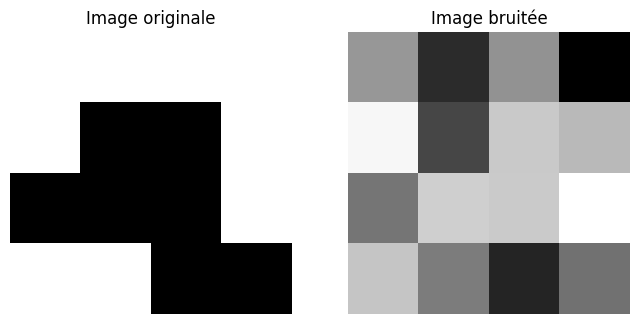

Amplitudes non nulles :
000000 (0.05826088234338539+0.05371379608194269j)
000001 (0.1929534449501049-0.05371379608192816j)
000100 (0.06493038162147564+0.1360778580361129j)
000101 (0.15803114166632304-0.1360778580361075j)
001000 (0.11653013786163538+0.11566692347048407j)
001001 (0.13330834195858535-0.11566692347047333j)
001100 (0.092213678372564+0.13077185777264902j)
001101 (0.11931959271779707-0.13077185777264574j)
010000 (0.11970634684790979+0.10709501584295167j)
010001 (0.15663911966440988-0.10709501584293771j)
010100 (0.09709661380768411+0.13576772444977514j)
010101 (0.13302755834232033-0.13576772444976937j)
011000 (0.11457375234237008+0.12172596560125755j)
011001 (0.1498473738657903-0.12172596560124767j)
011100 (0.11030062127400657+0.12381487433746247j)
011101 (0.14973747453188763-0.12381487433745783j)
100000 (0.10814556435269355+0.1316164667128313j)
100001 (0.13405131406944665-0.1316164667128171j)
100100 (0.11733074432896498+0.12503415703054535j)
100101 (0.14856337095585256-0.1250

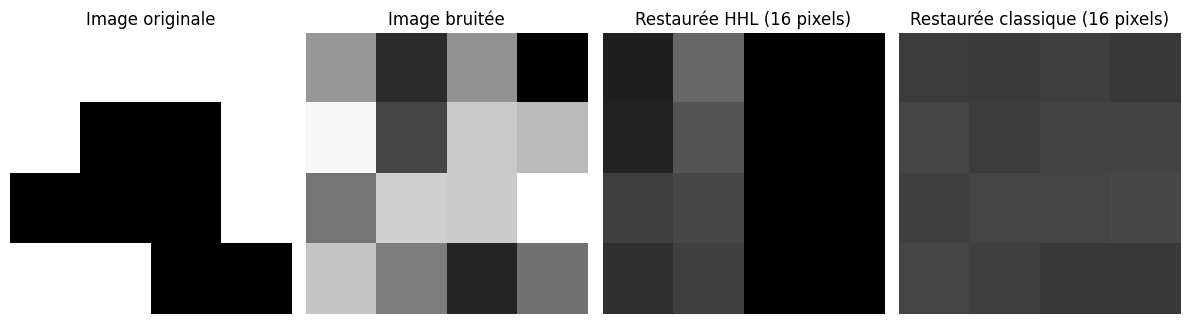

In [7]:
import numpy as np
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.color import rgb2gray
from scipy.linalg import expm
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate, Initialize
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

# 1. Charger et bruiter l'image caméraman (patch 4x4 = 16 pixels)
image = img_as_float(data.camera())
image = rgb2gray(image) if image.ndim == 3 else image
image = image[:4, :4]
noisy = random_noise(image, mode='gaussian', var=0.01)

# Affichage des images originale et bruitée
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Image bruitée")
plt.imshow(noisy, cmap='gray')
plt.axis('off')
plt.show()

# 2. Mise en forme du problème Ax = b (filtrage de Tikhonov)
y = noisy.flatten()
n = y.size  # n = 16
lambd = 0.1

I = np.eye(n)
L = np.diag(np.ones(n)) - np.diag(np.ones(n-1), k=1)
L = L + L.T
A = I + lambd * L

A = A / np.linalg.norm(A)
b = y / np.linalg.norm(y)

# On traite tous les pixels
A_hhl = A
b_hhl = b

eigvals, eigvecs = np.linalg.eigh(A_hhl)

n_phase = 1
n_ancilla = 1
n_solution = 4  # 4 qubits pour 16 pixels
n_qubits = n_phase + n_ancilla + n_solution  # 1+1+4=6

qc = QuantumCircuit(n_qubits)

# Préparation de |b> sur les 4 derniers qubits
b_hhl = b_hhl / np.linalg.norm(b_hhl)
init_gate = Initialize(b_hhl)
qc.append(init_gate, [2, 3, 4, 5])

# QPE (Hadamard sur le qubit de phase)
qc.h(0)

# Controlled-U = exp(i*A*t)
t = np.pi / (eigvals[-1] - eigvals[0])
U = expm(1j * A_hhl * t)
U_gate = UnitaryGate(U)
qc.append(U_gate.control(1), [0,2,3,4,5])

# Inverse QPE (Hadamard)
qc.h(0)

# Rotation conditionnelle sur l'ancilla selon la valeur propre
for idx, eig in enumerate(eigvals):
    val = 1 / eig
    if np.abs(val) > 1:
        val = np.sign(val)
    angle = -2 * np.arcsin(val)
    qc.cry(angle, 0, 1)

state = Statevector.from_instruction(qc).data

print("Amplitudes non nulles :")
for idx, amp in enumerate(state):
    if np.abs(amp) > 1e-6:
        print(format(idx, f'0{n_qubits}b'), amp)

# Extraction de la solution (phase et ancilla à 0)
solution = []
for idx, amp in enumerate(state):
    binaire = format(idx, f'0{n_qubits}b')
    # phase=0, ancilla=0, solution=qubits 2,3,4,5
    if binaire[:2] == '00':
        solution.append(amp)
solution = np.array(solution)
norm = np.linalg.norm(solution)
if norm > 0:
    solution = solution / norm
else:
    print("Aucune amplitude extraite, vérifiez la correspondance phase/valeur propre et la QPE.")

print("Vecteur solution normalisé (approximation HHL Qiskit, 16 pixels) :")
print(solution)

# Solution classique pour comparaison
sol_classique = np.linalg.solve(A_hhl, b_hhl)
sol_classique_norm = sol_classique / np.linalg.norm(sol_classique)
print("Solution classique :", sol_classique)
print("Solution classique normalisée :", sol_classique_norm)

# --- Affichage comparatif des résultats ---

# Image restaurée HHL (on connaît tous les pixels)
restauree_hhl = solution.real.reshape(image.shape)

# Image restaurée classique (Tikhonov)
restauree_classique = sol_classique_norm.reshape(image.shape)

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.title("Image originale")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Image bruitée")
plt.imshow(noisy, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Restaurée HHL (16 pixels)")
plt.imshow(restauree_hhl, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Restaurée classique (16 pixels)")
plt.imshow(restauree_classique, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.tight_layout()
plt.show()